In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats
import scipy.optimize
import numdifftools as nd
from numdifftools import Jacobian, Hessian
sns.set()

In [6]:
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [7]:
# BYMARKEDER
df = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Bresnahan/by%20markeder/Bresnahan_data_by.csv")

# KOMMUNEMARKEDER
#df = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Bresnahan/Bresnahan_data_full_l%C3%A6s%C3%B8.csv")

df = df.drop(['Unnamed: 0'], axis=1)

In [8]:
df

,Kommune,by,By_befolkning,ALDER,d65,d17,samlet_ind,Besk,Besk1864,DK,Befolkning,markedsvaerdix,yderkom,År,antal_apo
0,101,København,528208,35.67,0.10,0.17,195272.57,0.53,0.70,0.78,539542,1564751.11,0,2010,17
1,147,Frederiksberg,100115,39.06,0.16,0.17,222330.66,0.52,0.74,0.84,98782,1783339.80,0,2010,5
2,230,Rudersdal,40199,41.74,0.21,0.24,269124.85,0.48,0.78,0.90,54765,2904041.88,0,2010,3
3,240,Ølstykke-Stenløse,23556,38.39,0.15,0.27,223787.65,0.52,0.83,0.94,41614,1461145.92,0,2010,1
4,240,Veksø,1891,38.39,0.15,0.27,223787.65,0.52,0.83,0.94,41614,1461145.92,0,2010,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,820,Løgstør,4112,43.50,0.23,0.20,166023.23,0.49,0.76,0.91,37121,960791.40,0,2018,1
3497,183,Ishøj,22058,38.48,0.16,0.22,169250.18,0.48,0.72,0.60,22946,1459692.96,0,2018,1
3498,155,Søvang,13837,43.83,0.24,0.23,245042.36,0.49,0.83,0.92,14270,2653095.42,0,2018,1
3499,607,Fredericia,44394,42.01,0.21,0.20,184063.49,0.48,0.74,0.89,51427,1225318.90,0,2018,6


In [9]:
# df['Befolkning'] betyder at det er på kommuneniveau - er det korrekt?
df['receptgrænse'] = 270000*1.02317**(df['År']-2011)

år = list(range(2008,2019))
# vi har indsat 0 i år efter 2015 for at sikre at disse markeder ikke er restrikteret
gnsrecept = [13.1, 13.12, 13.19, 13.13, 13.24, 13.26, 13.53, 13.13, 0 ,0 ,0]
gnsreceptdic = {}
for i in range(len(gnsrecept)):
    gnsreceptdic[år[i]] = gnsrecept[i]
    
restriction = []

for år in range(2008,2019):
    liste = list((df['Befolkning'][df['År']==år]*gnsreceptdic[år]-df['receptgrænse'][df['År']==år]*df['antal_apo'][df['År']==år])>=df['receptgrænse'][df['År']==år])
    for i in liste:
        restriction.append(i)
        
df['restriction'] = restriction

In [10]:
## FIX YDERKOMMUNER ##
df_komkode_yder = pd.read_excel('kommunerkoderyder.xlsx')
df = df.merge(df_komkode_yder, on = "Kommune")
df  = df.drop('yderkom', axis = 1)
df = df.rename(columns={'Yderkommuner':'yderkom'})

In [11]:
df['yder_mono'] = ((df['antal_apo']<=1)* (df['yderkom']==1))
df['yder_mono'] = df['yder_mono'].astype(int)

C:\Users\Oliver\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [12]:
# KOMMUNER
#df['logbefolkning'] = df['Befolkning']/1000#df['By_befolkning']/1000

# BYMARKEDER
df['logbefolkning'] = df['By_befolkning']/1000#


###
df['logmarkedsvalue'] = df['markedsvaerdix']/100000 #np.log()
df['logindkomst'] = df['samlet_ind']/100000 #np.log()

# Unrestricted markets
#df = df[df['restriction']==True]

In [13]:
def V(df, Ni, alpha=np.ones(5), beta=np.ones(6)):
    """Per-capita variable profit
    
    df: data
    Ni: number of incumbents in market i
    alpha: alpha parameters
    beta: beta parameter
    """
    n = np.min([5, Ni])
#     n = Ni
    a = 0
    for i in range(1,n):
        a = a + alpha[i]
    

    Z = np.c_[df.d65, df.d17, df.logindkomst, df.Besk1864, df.DK, df.yder_mono]# np.log(), 

    # W = df.LANDV
    # X = np.c_[W, Z]

    X = np.c_[Z]
    
    
    profit = alpha[0] + X @ beta - a
    return profit

def F(df, Ni, gamma=np.ones(5)):
    n = np.min([5, Ni])
#     n = Ni
    g = 0
    # gamma 2 through gamma 5 (indices 1 through 4)
    for i in range(1,n):
        g = g + gamma[i]

    fixed_cost = gamma[0] + gamma[5]*df.logmarkedsvalue + g
    return fixed_cost

#def S_func(df, lam):
def S_func(df, lam): #, lam
    S =   lam * df.logbefolkning #np.log() #
    return S


def neg_log_lik(theta=np.ones(18), market='antal_apo', df=df):#, df=None):
    lam = theta[0]
    beta = theta[1:7]
    alpha = theta[7:12]
    gamma = theta[12:18]
#    beta = theta[0:5]
#    alpha = theta[5:10]
#    gamma = theta[10:16]
    
    
    Phi = scipy.stats.norm.cdf
    
    S = S_func(df, lam) #, lam

    
    P = [0] * 6
    Pi_bar = lambda N: S * V(df, N, alpha=alpha, beta=beta) - F(df, N, gamma=gamma)
    P[0] = np.log( 1 - Phi(Pi_bar(0)) )
    P[5] = np.log( Phi(Pi_bar(5)) )
    for i in range(1,5):
        P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )

        
    for i in range(6):
        P[i][P[i] == -np.inf] = -100000000
    log_lik = 0 
    for i in range(5):
        log_lik = log_lik + np.sum(P[i] * (df[market] == i))
    log_lik = log_lik + np.sum(P[5] * (df[market] >= 5))
    return -log_lik


def theta_to_param_dict(theta):
    lam = theta[0]
    beta = theta[1:7]
    alpha = theta[7:12]
    gamma = theta[12:18]
#    beta = theta[0:5]
#    alpha = theta[5:10]
#    gamma = theta[10:16]
    
    
    d = {'lam': lam, 'beta': beta, 'alpha': alpha, 'gamma': gamma, 'theta': theta} 
    return d

In [14]:
theta0 = np.ones(18) * 0.1
neg_log_lik(df=df, theta=theta0)

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log


6300.357484587363

In [15]:
df = df.sample(frac=1, random_state = 1).reset_index(drop=True)

In [16]:
%%time
ba = [-np.inf] * 7
bb = [0] * 10
lower_bounds = [*ba, *bb, -np.inf]
upper_bounds = [np.inf] * 18
bounds = list(zip(lower_bounds, upper_bounds))


theta0 = np.ones(18) * 0.1
nll = lambda theta: neg_log_lik(theta=theta, df=df)
out = scipy.optimize.minimize(nll, theta0, bounds=bounds,
    options={'disp': False, 'maxiter': 10000}
    )

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log


Wall time: 3min 38s


In [17]:
out

      fun: 2259.1850954075016
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.43289833e-02, -2.25645636e-01, -1.25874067e-01, -3.44971340e-01,
       -1.70803105e-01, -4.13911039e-01, -1.33059075e-01,  1.85520548e+01,
        3.41515261e-01,  5.32600097e-01,  3.06681613e-01, -1.51430868e-02,
       -5.87078830e-02, -5.86169335e-02, -4.18822310e-02, -5.13409759e-02,
       -1.24418875e-01,  3.91537469e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 11153
      nit: 515
   status: 0
  success: True
        x: array([ 4.53378717e-01,  9.35674627e-01, -2.64199670e+00, -1.27052246e-01,
        1.33974582e+00,  2.17411688e-01, -3.00122557e-03,  0.00000000e+00,
        3.08557150e-01,  9.31620336e-02,  3.19429085e-02,  1.00779285e-03,
        9.22171700e-01,  1.98432449e+00,  3.38118435e-01,  4.64034035e-01,
        4.57680726e-01,  9.96624275e-03])

In [18]:
N = len(df) #Korriger så det passer til antal observationer. 
test = out.hess_inv.todense()/N
se3 = np.sqrt(np.diag(test))
se3

array([0.025088  , 0.11855239, 0.03227462, 0.0275236 , 0.07458532,
       0.09965024, 0.04334351, 0.01690067, 0.05689169, 0.01590699,
       0.01508088, 0.02047478, 0.04447454, 0.1023255 , 0.08191243,
       0.10807178, 0.24443484, 0.01083931])

In [19]:
Hfun = nd.Hessian(nll, full_output=True)
hessian_nd, info= Hfun(out['x'])
se = np.sqrt(np.diag(np.linalg.inv(hessian_nd)))
results = pd.DataFrame({'parameters':out['x'],'std err':se, "std err diag":se3})
results.index=['lambda - befolkning','beta_1 - d65','beta_2 - d17','beta_3 - indkomst','beta_4 - besk','beta_5 - Foreigner', 'beta_6 - yderkom' ,'alpha_1','alpha_2','alpha_3','alpha_4','alpha_5','gamma_1','gamma_2','gamma_3','gamma_4','gamma_5', 'gamma_6 - Landvalue'] #,'gamma6' 
results

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


,parameters,std err,std err diag
lambda - befolkning,0.45,nan,0.03
beta_1 - d65,0.94,nan,0.12
beta_2 - d17,-2.64,nan,0.03
beta_3 - indkomst,-0.13,nan,0.03
beta_4 - besk,1.34,nan,0.07
beta_5 - Foreigner,0.22,0.05,0.10
beta_6 - yderkom,-0.00,0.02,0.04
alpha_1,0.00,0.10,0.02
alpha_2,0.31,nan,0.06
alpha_3,0.09,nan,0.02


In [20]:
hat_theta = theta_to_param_dict(out.x)

In [21]:
def calcS(df, theta):
    d = theta_to_param_dict(theta)
    S_grid = np.zeros(5)
    
    dfm = df.mean()
    for i in range(5):
        n = i + 1
        S_grid[i] = F(dfm, n, d['gamma']) / V(dfm, n, d['alpha'], d['beta'])
        print(F(dfm, n, d['gamma']) )
        print(V(dfm, n, d['alpha'], d['beta']))
    return S_grid

S_vals = calcS(df, out.x)

1.0441566240038918
[0.59859959]
3.028481112461598
[0.29004244]
3.366599547668887
[0.1968804]
3.8306335824964726
[0.1649375]
4.2883143083882125
[0.1639297]


In [22]:
S_vals

array([ 1.74433235, 10.44151033, 17.09971877, 23.22475893, 26.15947096])

In [23]:
table5A_left = pd.DataFrame({'Apoteker':S_vals}).T
table5A_left.columns = ['S_1', 'S_2', 'S_3', 'S_4', 'S_5']
table5A_left

,S_1,S_2,S_3,S_4,S_5
Apoteker,1.74,10.44,17.10,23.22,26.16


In [24]:
a = [S_vals[i+1]/S_vals[i] * ((i+1)/(i+2)) for i in range(4)]
table5A_right = pd.DataFrame(a).T
table5A_right.columns = ['s2/s1', 's3/s2', 's4/s3', 's5/s4']

In [25]:
table5A_right

,s2/s1,s3/s2,s4/s3,s5/s4
0,2.99,1.09,1.02,0.90


In [26]:
SN_S5_ratio = S_vals[5-1]* np.arange(1,5+1) / (S_vals * 5)

In [27]:
SN_S5_ratio

array([2.99936775, 1.0021336 , 0.91789127, 0.90108908, 1.        ])

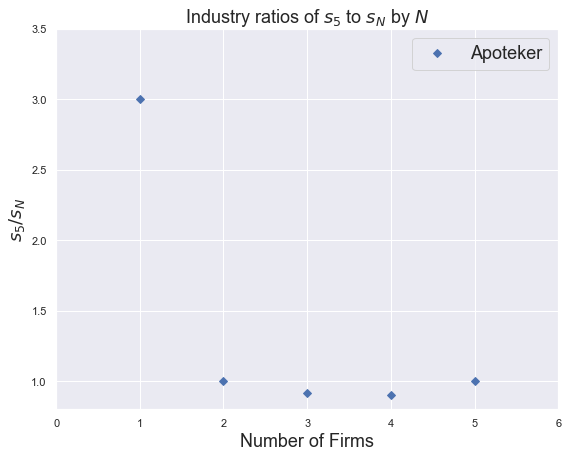

In [28]:
BIG = 18
fig = plt.figure(figsize=(9,7))
plt.plot([1,2,3,4,5], SN_S5_ratio, 'D', label='Apoteker')
ax = fig.get_axes()[0]
plt.legend(fontsize=BIG)
plt.xlim(0,6)
plt.ylim(0.8, 3.5)
plt.title('Industry ratios of $s_5$ to $s_N$ by $N$', fontsize=BIG)
plt.xlabel('Number of Firms', fontsize=BIG)
plt.ylabel('$s_5/s_N$', fontsize=BIG);
# ax.set_ylabel('$s_5/s_N$', fontsize=40)